In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from jcopdl.callback import Callback, set_config
import pandas as pd

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot: xlabel='Date'>

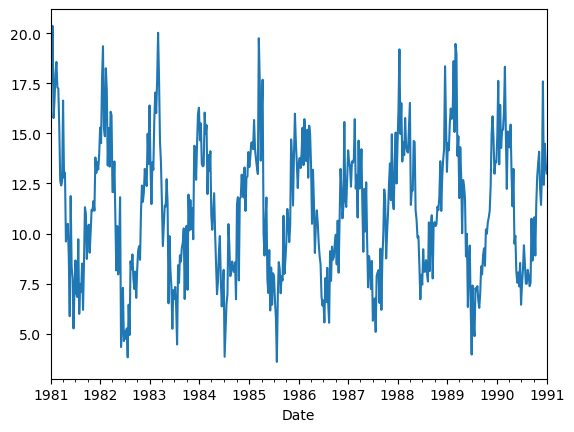

In [3]:
df = df.resample('W').mean()
df.Temp.plot()

In [4]:
t_train, t_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
t_train.shape, t_test.shape

((418, 1), (105, 1))

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

bs = 32
seq_len = 14

train_set = TimeSeriesDataset(t_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=False)

test_set = TimeSeriesDataset(t_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)
# N =  banyak data perbaris
# S = banyak baris
# F = banyak fitur

(N, S, F): (29, 14, 1)
Note: last 11 data excluded

(N, S, F): (7, 14, 1)
Note: last 6 data excluded



## Arch and config

In [6]:
from jcopdl.layers import linear_block

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout) # agar mengikuti algoritma rnn
        self.fc = nn.Linear(hidden_size, output_size) # nn biasa
        
    def forward(self, x, hidden): # hidde itu input setiap kali memory bergerak
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [8]:
config = set_config({
    "input_size ": train_set.n_feature, # cmn ada 1 fitur
    "output_size": 1, # output 1 fitur
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0,
    "seq_len": train_set.n_seq
})

## Trainig preparation (mcoc)

In [9]:
model = GRU(1, 1, 64, 2, 0).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/GRU")

## Training

In [10]:
# bppt = back prop true time

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost


Epoch     1
Train_cost  = 132.5414 | Test_cost  = 135.5621 | 

Epoch     2
Train_cost  = 128.7292 | Test_cost  = 131.6858 | 

Epoch     3
Train_cost  = 125.0021 | Test_cost  = 127.8833 | 

Epoch     4
Train_cost  = 121.3466 | Test_cost  = 124.1358 | 

Epoch     5
Train_cost  = 117.7421 | Test_cost  = 120.4238 | 

Epoch     6
Train_cost  = 114.1668 | Test_cost  = 116.7273 | 

Epoch     7
Train_cost  = 110.6063 | Test_cost  = 113.0335 | 

Epoch     8
Train_cost  = 107.0432 | Test_cost  = 109.3388 | 

Epoch     9
Train_cost  = 103.4767 | Test_cost  = 105.6466 | 

Epoch    10
Train_cost  = 99.9080 | Test_cost  = 101.9655 | 

Epoch    11
Train_cost  = 96.3456 | Test_cost  = 98.3097 | 

Epoch    12
Train_cost  = 92.8040 | Test_cost  = 94.6990 | 

Epoch    13
Train_cost  = 89.3013 | Test_cost  = 91.1582 | 

Epoch    14
Train_cost  = 85.8644 | Test_cost  = 87.7160 | 

Epoch    15
Train_cost  = 82.5203 | Test_cost  = 84.4008 | 

Epoch    16
Train_cost  = 79.2987 | Test_cost  = 81.2379 | 

Epoc

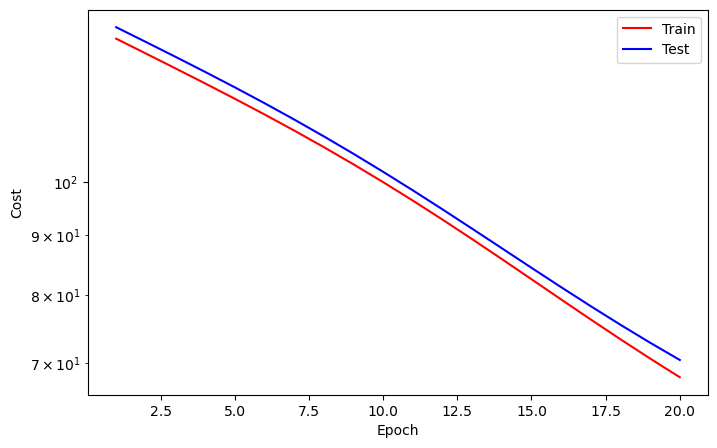


Epoch    21
Train_cost  = 65.6686 | Test_cost  = 68.1260 | 

Epoch    22
Train_cost  = 63.4748 | Test_cost  = 66.0331 | 

Epoch    23
Train_cost  = 61.4420 | Test_cost  = 64.0909 | 

Epoch    24
Train_cost  = 59.5565 | Test_cost  = 62.2846 | 

Epoch    25
Train_cost  = 57.8048 | Test_cost  = 60.5996 | 

Epoch    26
Train_cost  = 56.1709 | Test_cost  = 59.0223 | 

Epoch    27
Train_cost  = 54.6427 | Test_cost  = 57.5403 | 

Epoch    28
Train_cost  = 53.2071 | Test_cost  = 56.1425 | 

Epoch    29
Train_cost  = 51.8544 | Test_cost  = 54.8194 | 

Epoch    30
Train_cost  = 50.5745 | Test_cost  = 53.5625 | 

Epoch    31
Train_cost  = 49.3595 | Test_cost  = 52.3648 | 

Epoch    32
Train_cost  = 48.2019 | Test_cost  = 51.2199 | 

Epoch    33
Train_cost  = 47.0965 | Test_cost  = 50.1227 | 

Epoch    34
Train_cost  = 46.0375 | Test_cost  = 49.0685 | 

Epoch    35
Train_cost  = 45.0208 | Test_cost  = 48.0534 | 

Epoch    36
Train_cost  = 44.0421 | Test_cost  = 47.0739 | 

Epoch    37
Train_cost 

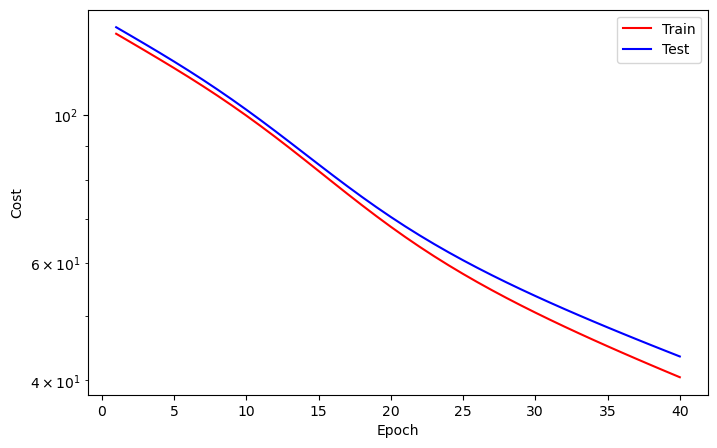


Epoch    41
Train_cost  = 39.6215 | Test_cost  = 42.6203 | 

Epoch    42
Train_cost  = 38.8164 | Test_cost  = 41.8047 | 

Epoch    43
Train_cost  = 38.0339 | Test_cost  = 41.0107 | 

Epoch    44
Train_cost  = 37.2726 | Test_cost  = 40.2372 | 

Epoch    45
Train_cost  = 36.5317 | Test_cost  = 39.4833 | 

Epoch    46
Train_cost  = 35.8099 | Test_cost  = 38.7479 | 

Epoch    47
Train_cost  = 35.1066 | Test_cost  = 38.0305 | 

Epoch    48
Train_cost  = 34.4211 | Test_cost  = 37.3303 | 

Epoch    49
Train_cost  = 33.7525 | Test_cost  = 36.6468 | 

Epoch    50
Train_cost  = 33.1003 | Test_cost  = 35.9793 | 

Epoch    51
Train_cost  = 32.4641 | Test_cost  = 35.3275 | 

Epoch    52
Train_cost  = 31.8434 | Test_cost  = 34.6911 | 

Epoch    53
Train_cost  = 31.2378 | Test_cost  = 34.0696 | 

Epoch    54
Train_cost  = 30.6470 | Test_cost  = 33.4629 | 

Epoch    55
Train_cost  = 30.0708 | Test_cost  = 32.8708 | 

Epoch    56
Train_cost  = 29.5090 | Test_cost  = 32.2930 | 

Epoch    57
Train_cost 

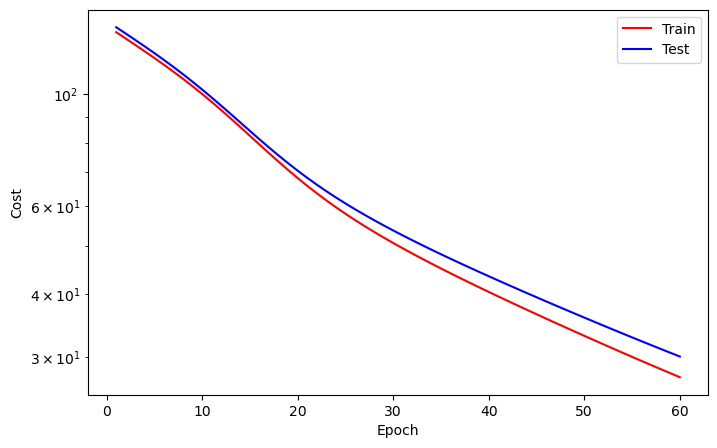


Epoch    61
Train_cost  = 26.9074 | Test_cost  = 29.6121 | 

Epoch    62
Train_cost  = 26.4268 | Test_cost  = 29.1158 | 

Epoch    63
Train_cost  = 25.9589 | Test_cost  = 28.6320 | 

Epoch    64
Train_cost  = 25.5033 | Test_cost  = 28.1606 | 

Epoch    65
Train_cost  = 25.0597 | Test_cost  = 27.7012 | 

Epoch    66
Train_cost  = 24.6279 | Test_cost  = 27.2535 | 

Epoch    67
Train_cost  = 24.2075 | Test_cost  = 26.8173 | 

Epoch    68
Train_cost  = 23.7982 | Test_cost  = 26.3922 | 

Epoch    69
Train_cost  = 23.4000 | Test_cost  = 25.9782 | 

Epoch    70
Train_cost  = 23.0124 | Test_cost  = 25.5748 | 

Epoch    71
Train_cost  = 22.6352 | Test_cost  = 25.1819 | 

Epoch    72
Train_cost  = 22.2683 | Test_cost  = 24.7993 | 

Epoch    73
Train_cost  = 21.9114 | Test_cost  = 24.4267 | 

Epoch    74
Train_cost  = 21.5642 | Test_cost  = 24.0639 | 

Epoch    75
Train_cost  = 21.2266 | Test_cost  = 23.7107 | 

Epoch    76
Train_cost  = 20.8984 | Test_cost  = 23.3669 | 

Epoch    77
Train_cost 

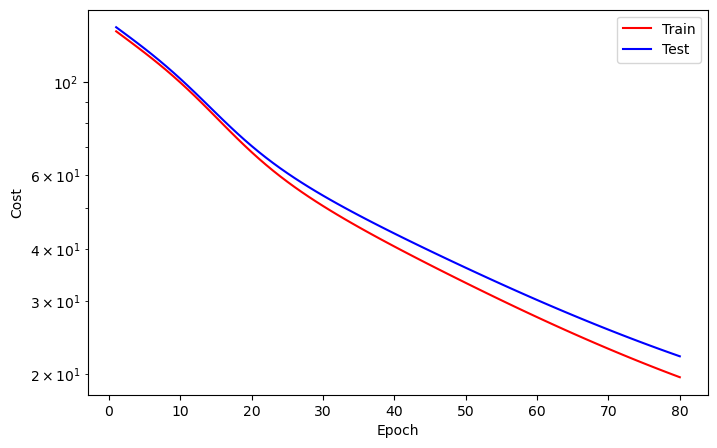


Epoch    81
Train_cost  = 19.3907 | Test_cost  = 21.7823 | 

Epoch    82
Train_cost  = 19.1145 | Test_cost  = 21.4908 | 

Epoch    83
Train_cost  = 18.8463 | Test_cost  = 21.2075 | 

Epoch    84
Train_cost  = 18.5859 | Test_cost  = 20.9320 | 

Epoch    85
Train_cost  = 18.3331 | Test_cost  = 20.6643 | 

Epoch    86
Train_cost  = 18.0878 | Test_cost  = 20.4042 | 

Epoch    87
Train_cost  = 17.8499 | Test_cost  = 20.1514 | 

Epoch    88
Train_cost  = 17.6191 | Test_cost  = 19.9058 | 

Epoch    89
Train_cost  = 17.3952 | Test_cost  = 19.6672 | 

Epoch    90
Train_cost  = 17.1781 | Test_cost  = 19.4356 | 

Epoch    91
Train_cost  = 16.9677 | Test_cost  = 19.2107 | 

Epoch    92
Train_cost  = 16.7638 | Test_cost  = 18.9923 | 

Epoch    93
Train_cost  = 16.5662 | Test_cost  = 18.7804 | 

Epoch    94
Train_cost  = 16.3747 | Test_cost  = 18.5747 | 

Epoch    95
Train_cost  = 16.1892 | Test_cost  = 18.3751 | 

Epoch    96
Train_cost  = 16.0097 | Test_cost  = 18.1815 | 

Epoch    97
Train_cost 

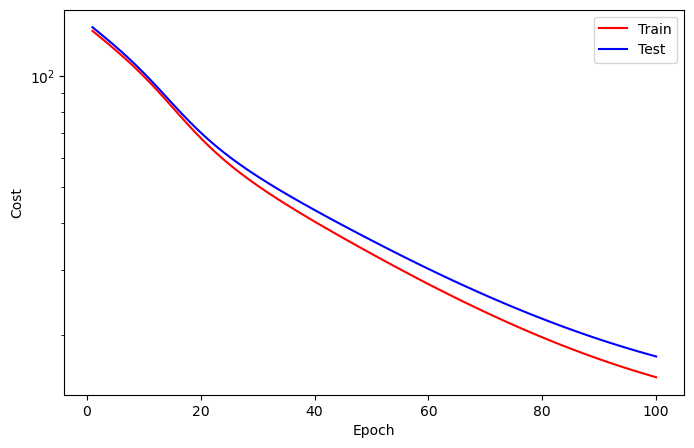


Epoch   101
Train_cost  = 15.1946 | Test_cost  = 17.2980 | 

Epoch   102
Train_cost  = 15.0472 | Test_cost  = 17.1371 | 

Epoch   103
Train_cost  = 14.9046 | Test_cost  = 16.9813 | 

Epoch   104
Train_cost  = 14.7668 | Test_cost  = 16.8304 | 

Epoch   105
Train_cost  = 14.6336 | Test_cost  = 16.6842 | 

Epoch   106
Train_cost  = 14.5050 | Test_cost  = 16.5426 | 

Epoch   107
Train_cost  = 14.3807 | Test_cost  = 16.4055 | 

Epoch   108
Train_cost  = 14.2606 | Test_cost  = 16.2727 | 

Epoch   109
Train_cost  = 14.1447 | Test_cost  = 16.1443 | 

Epoch   110
Train_cost  = 14.0328 | Test_cost  = 16.0199 | 

Epoch   111
Train_cost  = 13.9247 | Test_cost  = 15.8996 | 

Epoch   112
Train_cost  = 13.8205 | Test_cost  = 15.7832 | 

Epoch   113
Train_cost  = 13.7200 | Test_cost  = 15.6706 | 

Epoch   114
Train_cost  = 13.6230 | Test_cost  = 15.5617 | 

Epoch   115
Train_cost  = 13.5295 | Test_cost  = 15.4564 | 

Epoch   116
Train_cost  = 13.4394 | Test_cost  = 15.3545 | 

Epoch   117
Train_cost 

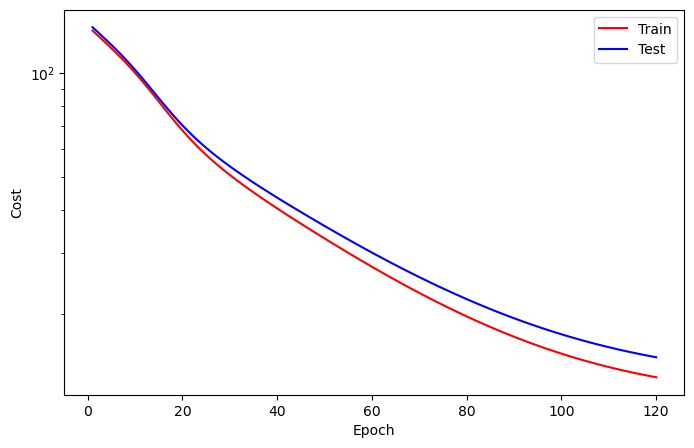


Epoch   121
Train_cost  = 13.0355 | Test_cost  = 14.8943 | 

Epoch   122
Train_cost  = 12.9635 | Test_cost  = 14.8114 | 

Epoch   123
Train_cost  = 12.8941 | Test_cost  = 14.7313 | 

Epoch   124
Train_cost  = 12.8274 | Test_cost  = 14.6540 | 

Epoch   125
Train_cost  = 12.7632 | Test_cost  = 14.5794 | 

Epoch   126
Train_cost  = 12.7015 | Test_cost  = 14.5073 | 

Epoch   127
Train_cost  = 12.6421 | Test_cost  = 14.4377 | 

Epoch   128
Train_cost  = 12.5850 | Test_cost  = 14.3706 | 

Epoch   129
Train_cost  = 12.5301 | Test_cost  = 14.3058 | 

Epoch   130
Train_cost  = 12.4774 | Test_cost  = 14.2432 | 

Epoch   131
Train_cost  = 12.4267 | Test_cost  = 14.1829 | 

Epoch   132
Train_cost  = 12.3780 | Test_cost  = 14.1247 | 

Epoch   133
Train_cost  = 12.3313 | Test_cost  = 14.0686 | 

Epoch   134
Train_cost  = 12.2864 | Test_cost  = 14.0145 | 

Epoch   135
Train_cost  = 12.2434 | Test_cost  = 13.9624 | 

Epoch   136
Train_cost  = 12.2020 | Test_cost  = 13.9121 | 

Epoch   137
Train_cost 

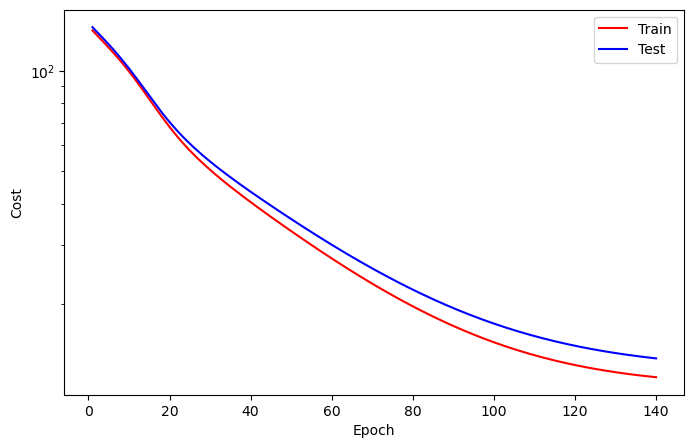


Epoch   141
Train_cost  = 12.0192 | Test_cost  = 13.6865 | 

Epoch   142
Train_cost  = 11.9871 | Test_cost  = 13.6462 | 

Epoch   143
Train_cost  = 11.9563 | Test_cost  = 13.6074 | 

Epoch   144
Train_cost  = 11.9267 | Test_cost  = 13.5700 | 

Epoch   145
Train_cost  = 11.8985 | Test_cost  = 13.5340 | 

Epoch   146
Train_cost  = 11.8714 | Test_cost  = 13.4993 | 

Epoch   147
Train_cost  = 11.8455 | Test_cost  = 13.4659 | 

Epoch   148
Train_cost  = 11.8206 | Test_cost  = 13.4338 | 

Epoch   149
Train_cost  = 11.7969 | Test_cost  = 13.4028 | 

Epoch   150
Train_cost  = 11.7742 | Test_cost  = 13.3730 | 

Epoch   151
Train_cost  = 11.7524 | Test_cost  = 13.3443 | 

Epoch   152
Train_cost  = 11.7316 | Test_cost  = 13.3167 | 

Epoch   153
Train_cost  = 11.7117 | Test_cost  = 13.2901 | 

Epoch   154
Train_cost  = 11.6927 | Test_cost  = 13.2645 | 

Epoch   155
Train_cost  = 11.6746 | Test_cost  = 13.2398 | 

Epoch   156
Train_cost  = 11.6572 | Test_cost  = 13.2161 | 

Epoch   157
Train_cost 

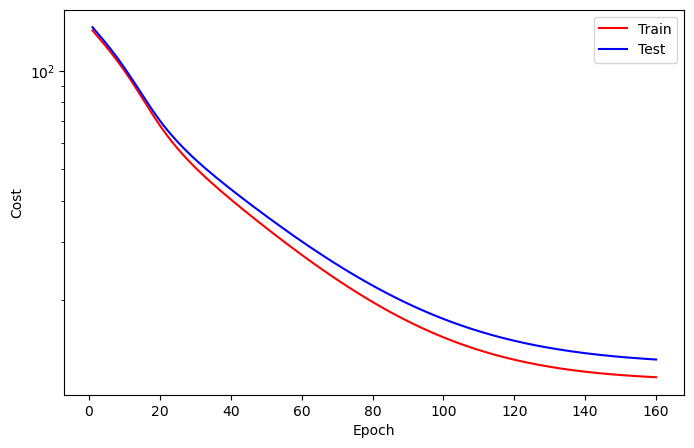


Epoch   161
Train_cost  = 11.5813 | Test_cost  = 13.1104 | 

Epoch   162
Train_cost  = 11.5682 | Test_cost  = 13.0916 | 

Epoch   163
Train_cost  = 11.5556 | Test_cost  = 13.0735 | 

Epoch   164
Train_cost  = 11.5436 | Test_cost  = 13.0561 | 

Epoch   165
Train_cost  = 11.5321 | Test_cost  = 13.0394 | 

Epoch   166
Train_cost  = 11.5212 | Test_cost  = 13.0233 | 

Epoch   167
Train_cost  = 11.5107 | Test_cost  = 13.0078 | 

Epoch   168
Train_cost  = 11.5008 | Test_cost  = 12.9929 | 

Epoch   169
Train_cost  = 11.4913 | Test_cost  = 12.9786 | 

Epoch   170
Train_cost  = 11.4822 | Test_cost  = 12.9648 | 

Epoch   171
Train_cost  = 11.4736 | Test_cost  = 12.9516 | 

Epoch   172
Train_cost  = 11.4654 | Test_cost  = 12.9388 | 

Epoch   173
Train_cost  = 11.4576 | Test_cost  = 12.9266 | 

Epoch   174
Train_cost  = 11.4501 | Test_cost  = 12.9148 | 

Epoch   175
Train_cost  = 11.4430 | Test_cost  = 12.9034 | 

Epoch   176
Train_cost  = 11.4362 | Test_cost  = 12.8925 | 

Epoch   177
Train_cost 

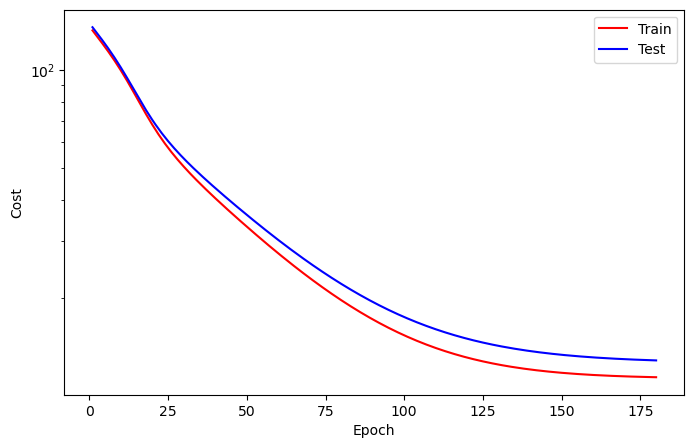


Epoch   181
Train_cost  = 11.4067 | Test_cost  = 12.8439 | 

Epoch   182
Train_cost  = 11.4017 | Test_cost  = 12.8353 | 

Epoch   183
Train_cost  = 11.3968 | Test_cost  = 12.8269 | 

Epoch   184
Train_cost  = 11.3922 | Test_cost  = 12.8189 | 

Epoch   185
Train_cost  = 11.3878 | Test_cost  = 12.8112 | 

Epoch   186
Train_cost  = 11.3837 | Test_cost  = 12.8038 | 

Epoch   187
Train_cost  = 11.3797 | Test_cost  = 12.7967 | 

Epoch   188
Train_cost  = 11.3759 | Test_cost  = 12.7899 | 

Epoch   189
Train_cost  = 11.3723 | Test_cost  = 12.7833 | 

Epoch   190
Train_cost  = 11.3688 | Test_cost  = 12.7769 | 

Epoch   191
Train_cost  = 11.3655 | Test_cost  = 12.7708 | 

Epoch   192
Train_cost  = 11.3624 | Test_cost  = 12.7649 | 

Epoch   193
Train_cost  = 11.3594 | Test_cost  = 12.7593 | 

Epoch   194
Train_cost  = 11.3566 | Test_cost  = 12.7538 | 

Epoch   195
Train_cost  = 11.3539 | Test_cost  = 12.7486 | 

Epoch   196
Train_cost  = 11.3513 | Test_cost  = 12.7435 | 

Epoch   197
Train_cost 

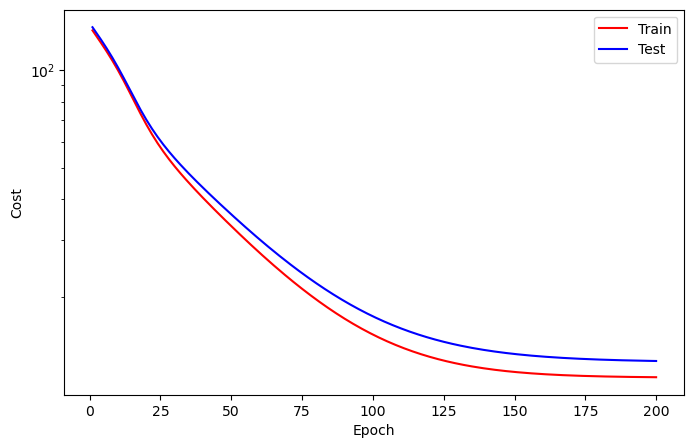


Epoch   201
Train_cost  = 11.3400 | Test_cost  = 12.7210 | 

Epoch   202
Train_cost  = 11.3381 | Test_cost  = 12.7170 | 

Epoch   203
Train_cost  = 11.3362 | Test_cost  = 12.7131 | 

Epoch   204
Train_cost  = 11.3344 | Test_cost  = 12.7094 | 

Epoch   205
Train_cost  = 11.3327 | Test_cost  = 12.7058 | 

Epoch   206
Train_cost  = 11.3311 | Test_cost  = 12.7023 | 

Epoch   207
Train_cost  = 11.3295 | Test_cost  = 12.6990 | 

Epoch   208
Train_cost  = 11.3280 | Test_cost  = 12.6957 | 

Epoch   209
Train_cost  = 11.3266 | Test_cost  = 12.6926 | 

Epoch   210
Train_cost  = 11.3252 | Test_cost  = 12.6896 | 

Epoch   211
Train_cost  = 11.3239 | Test_cost  = 12.6868 | 

Epoch   212
Train_cost  = 11.3226 | Test_cost  = 12.6840 | 

Epoch   213
Train_cost  = 11.3214 | Test_cost  = 12.6813 | 

Epoch   214
Train_cost  = 11.3203 | Test_cost  = 12.6787 | 

Epoch   215
Train_cost  = 11.3192 | Test_cost  = 12.6762 | 

Epoch   216
Train_cost  = 11.3181 | Test_cost  = 12.6738 | 

Epoch   217
Train_cost 

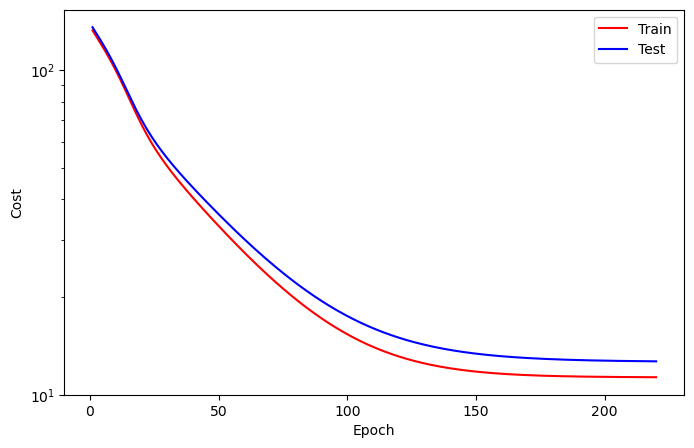


Epoch   221
Train_cost  = 11.3133 | Test_cost  = 12.6630 | 

Epoch   222
Train_cost  = 11.3124 | Test_cost  = 12.6611 | 

Epoch   223
Train_cost  = 11.3116 | Test_cost  = 12.6592 | 

Epoch   224
Train_cost  = 11.3108 | Test_cost  = 12.6574 | 

Epoch   225
Train_cost  = 11.3100 | Test_cost  = 12.6557 | 

Epoch   226
Train_cost  = 11.3093 | Test_cost  = 12.6540 | 

Epoch   227
Train_cost  = 11.3086 | Test_cost  = 12.6524 | 

Epoch   228
Train_cost  = 11.3079 | Test_cost  = 12.6508 | 

Epoch   229
Train_cost  = 11.3072 | Test_cost  = 12.6493 | 

Epoch   230
Train_cost  = 11.3065 | Test_cost  = 12.6478 | 

Epoch   231
Train_cost  = 11.3059 | Test_cost  = 12.6464 | 

Epoch   232
Train_cost  = 11.3052 | Test_cost  = 12.6450 | 

Epoch   233
Train_cost  = 11.3046 | Test_cost  = 12.6437 | 

Epoch   234
Train_cost  = 11.3041 | Test_cost  = 12.6425 | 

Epoch   235
Train_cost  = 11.3035 | Test_cost  = 12.6412 | 

Epoch   236
Train_cost  = 11.3029 | Test_cost  = 12.6400 | 

Epoch   237
Train_cost 

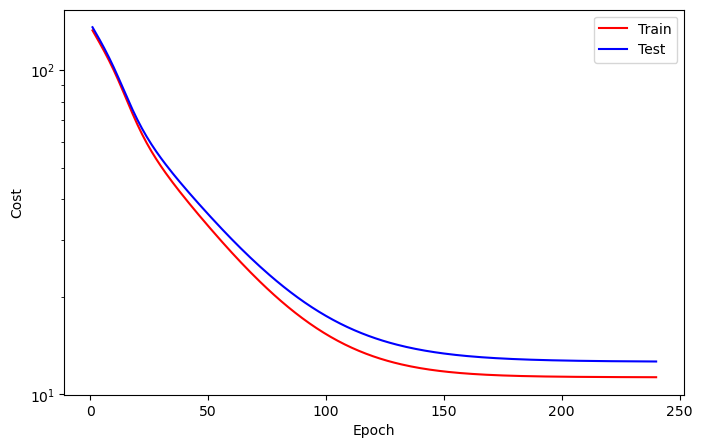


Epoch   241
Train_cost  = 11.3003 | Test_cost  = 12.6346 | 

Epoch   242
Train_cost  = 11.2998 | Test_cost  = 12.6336 | 

Epoch   243
Train_cost  = 11.2993 | Test_cost  = 12.6327 | 

Epoch   244
Train_cost  = 11.2988 | Test_cost  = 12.6318 | 

Epoch   245
Train_cost  = 11.2984 | Test_cost  = 12.6309 | 

Epoch   246
Train_cost  = 11.2979 | Test_cost  = 12.6300 | 

Epoch   247
Train_cost  = 11.2975 | Test_cost  = 12.6292 | 

Epoch   248
Train_cost  = 11.2970 | Test_cost  = 12.6284 | 

Epoch   249
Train_cost  = 11.2966 | Test_cost  = 12.6276 | 

Epoch   250
Train_cost  = 11.2961 | Test_cost  = 12.6269 | 

Epoch   251
Train_cost  = 11.2957 | Test_cost  = 12.6261 | 

Epoch   252
Train_cost  = 11.2953 | Test_cost  = 12.6254 | 

Epoch   253
Train_cost  = 11.2949 | Test_cost  = 12.6247 | 

Epoch   254
Train_cost  = 11.2945 | Test_cost  = 12.6241 | 

Epoch   255
Train_cost  = 11.2941 | Test_cost  = 12.6234 | 

Epoch   256
Train_cost  = 11.2937 | Test_cost  = 12.6228 | 

Epoch   257
Train_cost 

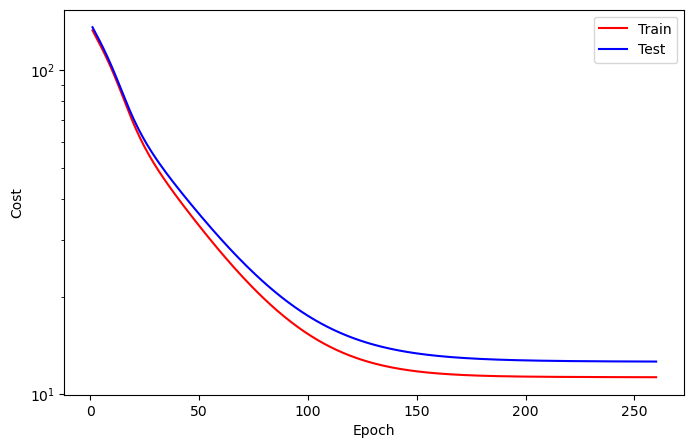


Epoch   261
Train_cost  = 11.2918 | Test_cost  = 12.6199 | 

Epoch   262
Train_cost  = 11.2914 | Test_cost  = 12.6194 | 

Epoch   263
Train_cost  = 11.2910 | Test_cost  = 12.6188 | 

Epoch   264
Train_cost  = 11.2906 | Test_cost  = 12.6183 | 

Epoch   265
Train_cost  = 11.2903 | Test_cost  = 12.6179 | 

Epoch   266
Train_cost  = 11.2899 | Test_cost  = 12.6174 | 

Epoch   267
Train_cost  = 11.2895 | Test_cost  = 12.6169 | 

Epoch   268
Train_cost  = 11.2892 | Test_cost  = 12.6165 | 

Epoch   269
Train_cost  = 11.2888 | Test_cost  = 12.6160 | 

Epoch   270
Train_cost  = 11.2885 | Test_cost  = 12.6156 | 

Epoch   271
Train_cost  = 11.2881 | Test_cost  = 12.6152 | 

Epoch   272
Train_cost  = 11.2877 | Test_cost  = 12.6148 | 

Epoch   273
Train_cost  = 11.2874 | Test_cost  = 12.6143 | 

Epoch   274
Train_cost  = 11.2871 | Test_cost  = 12.6140 | 

Epoch   275
Train_cost  = 11.2867 | Test_cost  = 12.6136 | 

Epoch   276
Train_cost  = 11.2864 | Test_cost  = 12.6132 | 

Epoch   277
Train_cost 

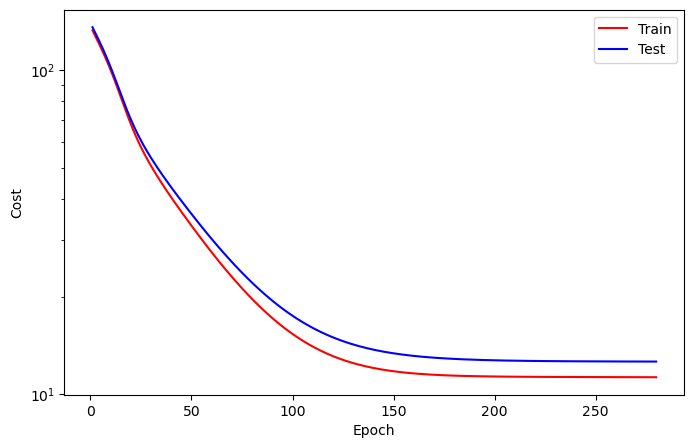


Epoch   281
Train_cost  = 11.2846 | Test_cost  = 12.6114 | 

Epoch   282
Train_cost  = 11.2843 | Test_cost  = 12.6111 | 

Epoch   283
Train_cost  = 11.2839 | Test_cost  = 12.6107 | 

Epoch   284
Train_cost  = 11.2836 | Test_cost  = 12.6104 | 

Epoch   285
Train_cost  = 11.2832 | Test_cost  = 12.6101 | 

Epoch   286
Train_cost  = 11.2829 | Test_cost  = 12.6097 | 

Epoch   287
Train_cost  = 11.2825 | Test_cost  = 12.6094 | 

Epoch   288
Train_cost  = 11.2822 | Test_cost  = 12.6091 | 

Epoch   289
Train_cost  = 11.2818 | Test_cost  = 12.6088 | 

Epoch   290
Train_cost  = 11.2815 | Test_cost  = 12.6085 | 

Epoch   291
Train_cost  = 11.2811 | Test_cost  = 12.6082 | 

Epoch   292
Train_cost  = 11.2808 | Test_cost  = 12.6079 | 

Epoch   293
Train_cost  = 11.2805 | Test_cost  = 12.6076 | 

Epoch   294
Train_cost  = 11.2801 | Test_cost  = 12.6073 | 

Epoch   295
Train_cost  = 11.2797 | Test_cost  = 12.6070 | 

Epoch   296
Train_cost  = 11.2794 | Test_cost  = 12.6067 | 

Epoch   297
Train_cost 

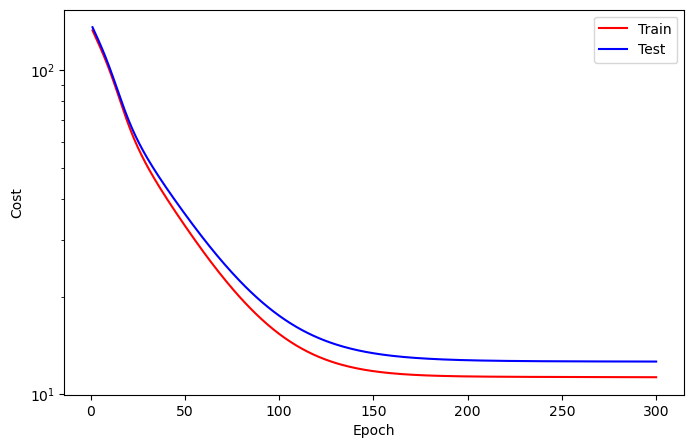


Epoch   301
Train_cost  = 11.2775 | Test_cost  = 12.6052 | 

Epoch   302
Train_cost  = 11.2772 | Test_cost  = 12.6049 | 

Epoch   303
Train_cost  = 11.2768 | Test_cost  = 12.6045 | 

Epoch   304
Train_cost  = 11.2764 | Test_cost  = 12.6042 | 

Epoch   305
Train_cost  = 11.2760 | Test_cost  = 12.6039 | 

Epoch   306
Train_cost  = 11.2756 | Test_cost  = 12.6036 | 

Epoch   307
Train_cost  = 11.2752 | Test_cost  = 12.6033 | 

Epoch   308
Train_cost  = 11.2748 | Test_cost  = 12.6030 | 

Epoch   309
Train_cost  = 11.2744 | Test_cost  = 12.6026 | 

Epoch   310
Train_cost  = 11.2740 | Test_cost  = 12.6023 | 

Epoch   311
Train_cost  = 11.2736 | Test_cost  = 12.6020 | 

Epoch   312
Train_cost  = 11.2731 | Test_cost  = 12.6016 | 

Epoch   313
Train_cost  = 11.2727 | Test_cost  = 12.6013 | 

Epoch   314
Train_cost  = 11.2722 | Test_cost  = 12.6009 | 

Epoch   315
Train_cost  = 11.2718 | Test_cost  = 12.6005 | 

Epoch   316
Train_cost  = 11.2713 | Test_cost  = 12.6001 | 

Epoch   317
Train_cost 

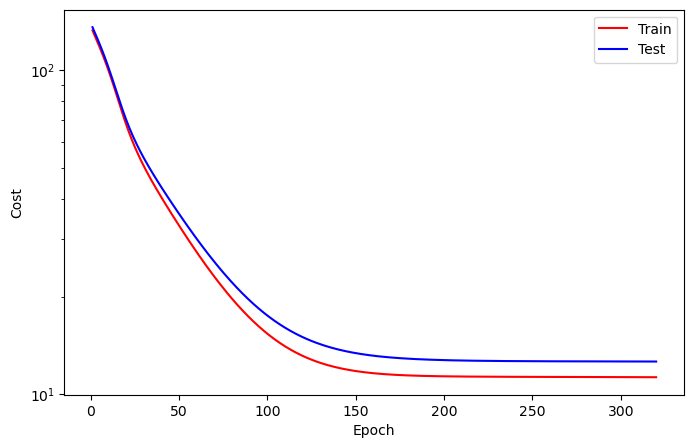


Epoch   321
Train_cost  = 11.2688 | Test_cost  = 12.5981 | 

Epoch   322
Train_cost  = 11.2683 | Test_cost  = 12.5976 | 

Epoch   323
Train_cost  = 11.2677 | Test_cost  = 12.5971 | 

Epoch   324
Train_cost  = 11.2671 | Test_cost  = 12.5966 | 

Epoch   325
Train_cost  = 11.2665 | Test_cost  = 12.5961 | 

Epoch   326
Train_cost  = 11.2659 | Test_cost  = 12.5956 | 

Epoch   327
Train_cost  = 11.2653 | Test_cost  = 12.5950 | 

Epoch   328
Train_cost  = 11.2646 | Test_cost  = 12.5944 | 

Epoch   329
Train_cost  = 11.2639 | Test_cost  = 12.5938 | 

Epoch   330
Train_cost  = 11.2632 | Test_cost  = 12.5931 | 

Epoch   331
Train_cost  = 11.2624 | Test_cost  = 12.5925 | 

Epoch   332
Train_cost  = 11.2616 | Test_cost  = 12.5917 | 

Epoch   333
Train_cost  = 11.2608 | Test_cost  = 12.5910 | 

Epoch   334
Train_cost  = 11.2599 | Test_cost  = 12.5902 | 

Epoch   335
Train_cost  = 11.2590 | Test_cost  = 12.5893 | 

Epoch   336
Train_cost  = 11.2580 | Test_cost  = 12.5884 | 

Epoch   337
Train_cost 

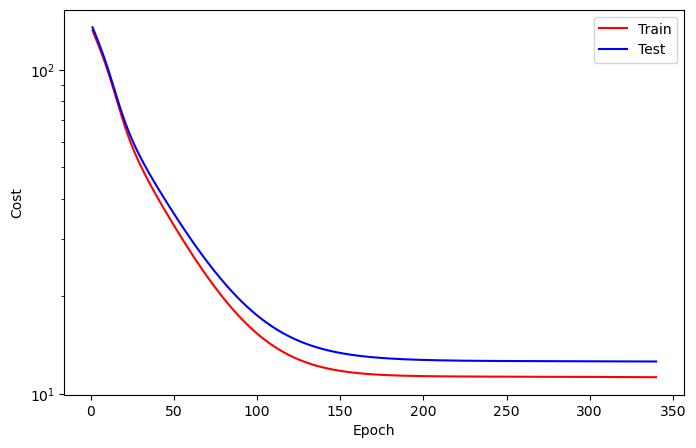


Epoch   341
Train_cost  = 11.2522 | Test_cost  = 12.5829 | 

Epoch   342
Train_cost  = 11.2508 | Test_cost  = 12.5816 | 

Epoch   343
Train_cost  = 11.2493 | Test_cost  = 12.5802 | 

Epoch   344
Train_cost  = 11.2477 | Test_cost  = 12.5787 | 

Epoch   345
Train_cost  = 11.2460 | Test_cost  = 12.5771 | 

Epoch   346
Train_cost  = 11.2443 | Test_cost  = 12.5754 | 

Epoch   347
Train_cost  = 11.2424 | Test_cost  = 12.5737 | 

Epoch   348
Train_cost  = 11.2404 | Test_cost  = 12.5718 | 

Epoch   349
Train_cost  = 11.2383 | Test_cost  = 12.5698 | 

Epoch   350
Train_cost  = 11.2360 | Test_cost  = 12.5678 | 

Epoch   351
Train_cost  = 11.2336 | Test_cost  = 12.5655 | 

Epoch   352
Train_cost  = 11.2311 | Test_cost  = 12.5632 | 

Epoch   353
Train_cost  = 11.2284 | Test_cost  = 12.5607 | 

Epoch   354
Train_cost  = 11.2255 | Test_cost  = 12.5581 | 

Epoch   355
Train_cost  = 11.2224 | Test_cost  = 12.5552 | 

Epoch   356
Train_cost  = 11.2191 | Test_cost  = 12.5522 | 

Epoch   357
Train_cost 

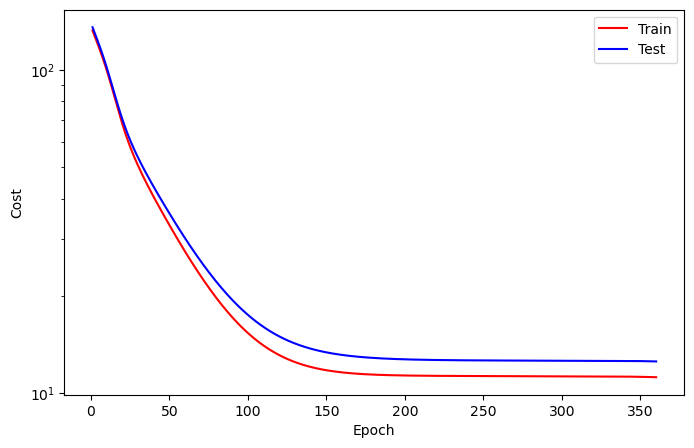


Epoch   361
Train_cost  = 11.1989 | Test_cost  = 12.5333 | 

Epoch   362
Train_cost  = 11.1939 | Test_cost  = 12.5286 | 

Epoch   363
Train_cost  = 11.1886 | Test_cost  = 12.5234 | 

Epoch   364
Train_cost  = 11.1829 | Test_cost  = 12.5179 | 

Epoch   365
Train_cost  = 11.1769 | Test_cost  = 12.5119 | 

Epoch   366
Train_cost  = 11.1704 | Test_cost  = 12.5056 | 

Epoch   367
Train_cost  = 11.1637 | Test_cost  = 12.4989 | 

Epoch   368
Train_cost  = 11.1567 | Test_cost  = 12.4921 | 

Epoch   369
Train_cost  = 11.1495 | Test_cost  = 12.4852 | 

Epoch   370
Train_cost  = 11.1422 | Test_cost  = 12.4783 | 

Epoch   371
Train_cost  = 11.1350 | Test_cost  = 12.4714 | 

Epoch   372
Train_cost  = 11.1277 | Test_cost  = 12.4646 | 

Epoch   373
Train_cost  = 11.1205 | Test_cost  = 12.4576 | 

Epoch   374
Train_cost  = 11.1133 | Test_cost  = 12.4504 | 

Epoch   375
Train_cost  = 11.1060 | Test_cost  = 12.4431 | 

Epoch   376
Train_cost  = 11.0987 | Test_cost  = 12.4356 | 

Epoch   377
Train_cost 

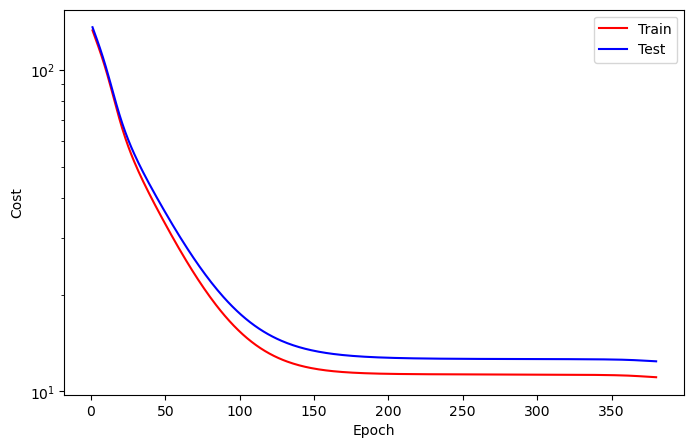


Epoch   381
Train_cost  = 11.0632 | Test_cost  = 12.3969 | 

Epoch   382
Train_cost  = 11.0561 | Test_cost  = 12.3882 | 

Epoch   383
Train_cost  = 11.0489 | Test_cost  = 12.3790 | 

Epoch   384
Train_cost  = 11.0412 | Test_cost  = 12.3691 | 

Epoch   385
Train_cost  = 11.0332 | Test_cost  = 12.3586 | 

Epoch   386
Train_cost  = 11.0248 | Test_cost  = 12.3476 | 

Epoch   387
Train_cost  = 11.0160 | Test_cost  = 12.3361 | 

Epoch   388
Train_cost  = 11.0069 | Test_cost  = 12.3243 | 

Epoch   389
Train_cost  = 10.9975 | Test_cost  = 12.3121 | 

Epoch   390
Train_cost  = 10.9879 | Test_cost  = 12.2998 | 

Epoch   391
Train_cost  = 10.9781 | Test_cost  = 12.2873 | 

Epoch   392
Train_cost  = 10.9683 | Test_cost  = 12.2747 | 

Epoch   393
Train_cost  = 10.9583 | Test_cost  = 12.2619 | 

Epoch   394
Train_cost  = 10.9482 | Test_cost  = 12.2490 | 

Epoch   395
Train_cost  = 10.9378 | Test_cost  = 12.2357 | 

Epoch   396
Train_cost  = 10.9272 | Test_cost  = 12.2221 | 

Epoch   397
Train_cost 

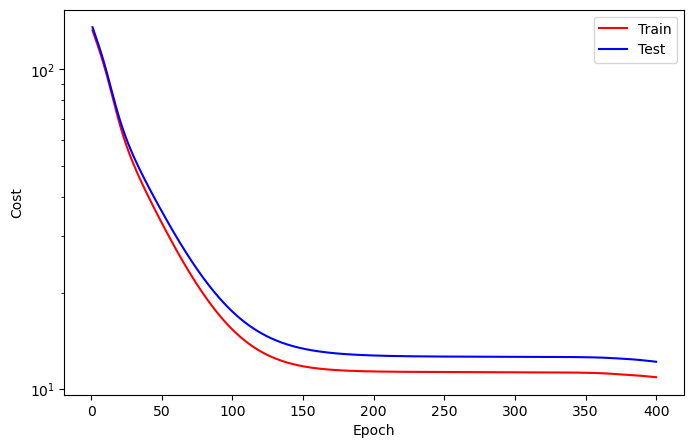


Epoch   401
Train_cost  = 10.8672 | Test_cost  = 12.1467 | 

Epoch   402
Train_cost  = 10.8533 | Test_cost  = 12.1297 | 

Epoch   403
Train_cost  = 10.8386 | Test_cost  = 12.1117 | 

Epoch   404
Train_cost  = 10.8228 | Test_cost  = 12.0926 | 

Epoch   405
Train_cost  = 10.8056 | Test_cost  = 12.0720 | 

Epoch   406
Train_cost  = 10.7870 | Test_cost  = 12.0495 | 

Epoch   407
Train_cost  = 10.7663 | Test_cost  = 12.0246 | 

Epoch   408
Train_cost  = 10.7433 | Test_cost  = 11.9967 | 

Epoch   409
Train_cost  = 10.7170 | Test_cost  = 11.9651 | 

Epoch   410
Train_cost  = 10.6870 | Test_cost  = 11.9294 | 

Epoch   411
Train_cost  = 10.6527 | Test_cost  = 11.8895 | 

Epoch   412
Train_cost  = 10.6143 | Test_cost  = 11.8466 | 

Epoch   413
Train_cost  = 10.5723 | Test_cost  = 11.8031 | 

Epoch   414
Train_cost  = 10.5293 | Test_cost  = 11.7624 | 

Epoch   415
Train_cost  = 10.4883 | Test_cost  = 11.7278 | 

Epoch   416
Train_cost  = 10.4525 | Test_cost  = 11.7002 | 

Epoch   417
Train_cost 

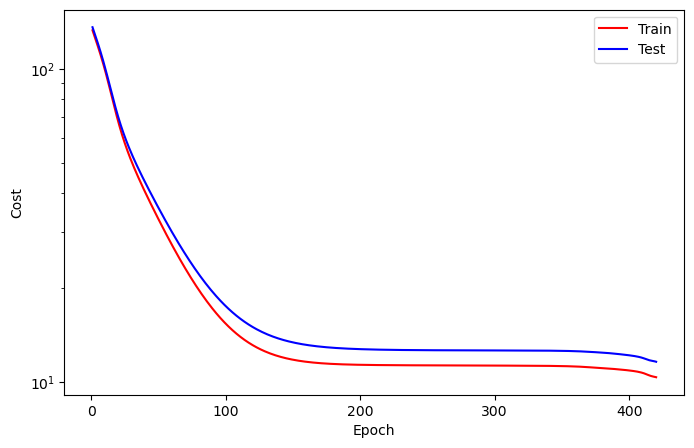


Epoch   421
Train_cost  = 10.3263 | Test_cost  = 11.5631 | 

Epoch   422
Train_cost  = 10.2948 | Test_cost  = 11.5206 | 

Epoch   423
Train_cost  = 10.2595 | Test_cost  = 11.4745 | 

Epoch   424
Train_cost  = 10.2212 | Test_cost  = 11.4269 | 

Epoch   425
Train_cost  = 10.1813 | Test_cost  = 11.3793 | 

Epoch   426
Train_cost  = 10.1414 | Test_cost  = 11.3324 | 

Epoch   427
Train_cost  = 10.1016 | Test_cost  = 11.2864 | 

Epoch   428
Train_cost  = 10.0620 | Test_cost  = 11.2409 | 

Epoch   429
Train_cost  = 10.0219 | Test_cost  = 11.1952 | 

Epoch   430
Train_cost  = 9.9810 | Test_cost  = 11.1484 | 

Epoch   431
Train_cost  = 9.9389 | Test_cost  = 11.1003 | 

Epoch   432
Train_cost  = 9.8954 | Test_cost  = 11.0510 | 

Epoch   433
Train_cost  = 9.8509 | Test_cost  = 11.0008 | 

Epoch   434
Train_cost  = 9.8053 | Test_cost  = 10.9499 | 

Epoch   435
Train_cost  = 9.7588 | Test_cost  = 10.8983 | 

Epoch   436
Train_cost  = 9.7111 | Test_cost  = 10.8457 | 

Epoch   437
Train_cost  = 9.66

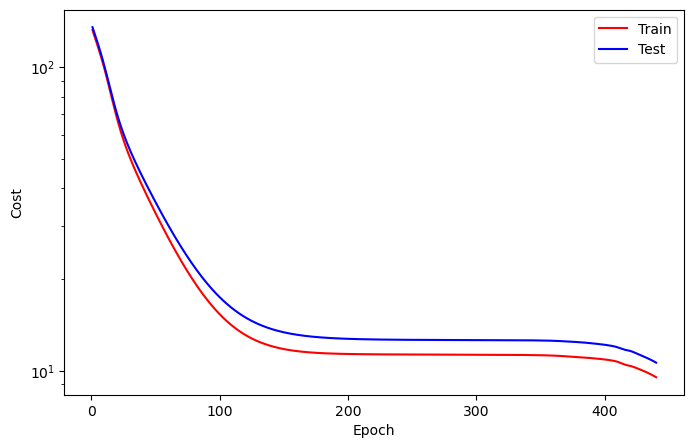


Epoch   441
Train_cost  = 9.4540 | Test_cost  = 10.5641 | 

Epoch   442
Train_cost  = 9.3990 | Test_cost  = 10.5049 | 

Epoch   443
Train_cost  = 9.3431 | Test_cost  = 10.4447 | 

Epoch   444
Train_cost  = 9.2862 | Test_cost  = 10.3831 | 

Epoch   445
Train_cost  = 9.2279 | Test_cost  = 10.3197 | 

Epoch   446
Train_cost  = 9.1681 | Test_cost  = 10.2539 | 

Epoch   447
Train_cost  = 9.1063 | Test_cost  = 10.1853 | 

Epoch   448
Train_cost  = 9.0417 | Test_cost  = 10.1133 | 

Epoch   449
Train_cost  = 8.9744 | Test_cost  = 10.0375 | 

Epoch   450
Train_cost  = 8.9041 | Test_cost  = 9.9584 | 

Epoch   451
Train_cost  = 8.8313 | Test_cost  = 9.8766 | 

Epoch   452
Train_cost  = 8.7565 | Test_cost  = 9.7933 | 

Epoch   453
Train_cost  = 8.6809 | Test_cost  = 9.7093 | 

Epoch   454
Train_cost  = 8.6051 | Test_cost  = 9.6255 | 

Epoch   455
Train_cost  = 8.5299 | Test_cost  = 9.5423 | 

Epoch   456
Train_cost  = 8.4555 | Test_cost  = 9.4596 | 

Epoch   457
Train_cost  = 8.3820 | Test_cost  

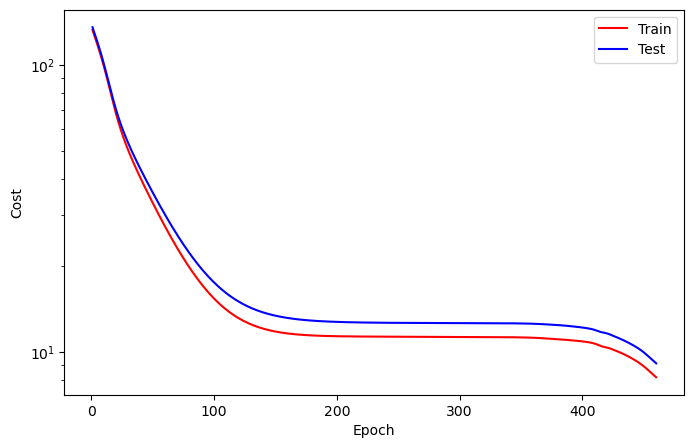


Epoch   461
Train_cost  = 8.0855 | Test_cost  = 9.0378 | 

Epoch   462
Train_cost  = 8.0070 | Test_cost  = 8.9456 | 

Epoch   463
Train_cost  = 7.9246 | Test_cost  = 8.8476 | 

Epoch   464
Train_cost  = 7.8364 | Test_cost  = 8.7418 | 

Epoch   465
Train_cost  = 7.7406 | Test_cost  = 8.6262 | 

Epoch   466
Train_cost  = 7.6352 | Test_cost  = 8.4994 | 

Epoch   467
Train_cost  = 7.5191 | Test_cost  = 8.3620 | 

Epoch   468
Train_cost  = 7.3926 | Test_cost  = 8.2166 | 

Epoch   469
Train_cost  = 7.2588 | Test_cost  = 8.0677 | 

Epoch   470
Train_cost  = 7.1223 | Test_cost  = 7.9200 | 

Epoch   471
Train_cost  = 6.9881 | Test_cost  = 7.7764 | 

Epoch   472
Train_cost  = 6.8605 | Test_cost  = 7.6388 | 

Epoch   473
Train_cost  = 6.7418 | Test_cost  = 7.5078 | 

Epoch   474
Train_cost  = 6.6329 | Test_cost  = 7.3845 | 

Epoch   475
Train_cost  = 6.5337 | Test_cost  = 7.2696 | 

Epoch   476
Train_cost  = 6.4444 | Test_cost  = 7.1644 | 

Epoch   477
Train_cost  = 6.3647 | Test_cost  = 7.0696 

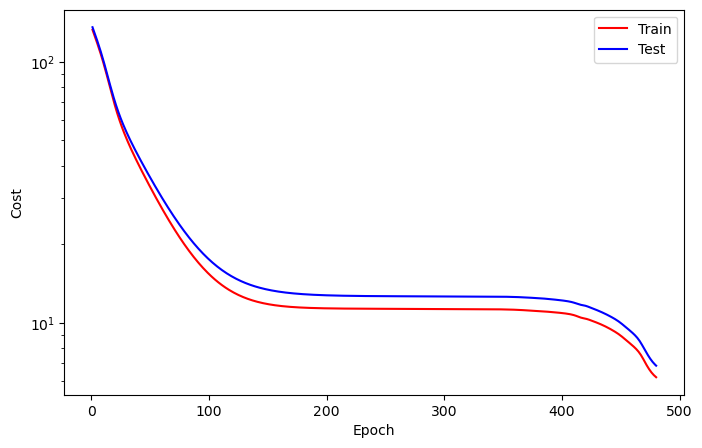


Epoch   481
Train_cost  = 6.1256 | Test_cost  = 6.7738 | 

Epoch   482
Train_cost  = 6.0786 | Test_cost  = 6.7129 | 

Epoch   483
Train_cost  = 6.0339 | Test_cost  = 6.6540 | 

Epoch   484
Train_cost  = 5.9904 | Test_cost  = 6.5964 | 

Epoch   485
Train_cost  = 5.9472 | Test_cost  = 6.5398 | 

Epoch   486
Train_cost  = 5.9037 | Test_cost  = 6.4839 | 

Epoch   487
Train_cost  = 5.8599 | Test_cost  = 6.4289 | 

Epoch   488
Train_cost  = 5.8156 | Test_cost  = 6.3750 | 

Epoch   489
Train_cost  = 5.7712 | Test_cost  = 6.3225 | 

Epoch   490
Train_cost  = 5.7272 | Test_cost  = 6.2716 | 

Epoch   491
Train_cost  = 5.6842 | Test_cost  = 6.2222 | 

Epoch   492
Train_cost  = 5.6427 | Test_cost  = 6.1739 | 

Epoch   493
Train_cost  = 5.6027 | Test_cost  = 6.1262 | 

Epoch   494
Train_cost  = 5.5642 | Test_cost  = 6.0790 | 

Epoch   495
Train_cost  = 5.5268 | Test_cost  = 6.0319 | 

Epoch   496
Train_cost  = 5.4904 | Test_cost  = 5.9851 | 

Epoch   497
Train_cost  = 5.4551 | Test_cost  = 5.9388 

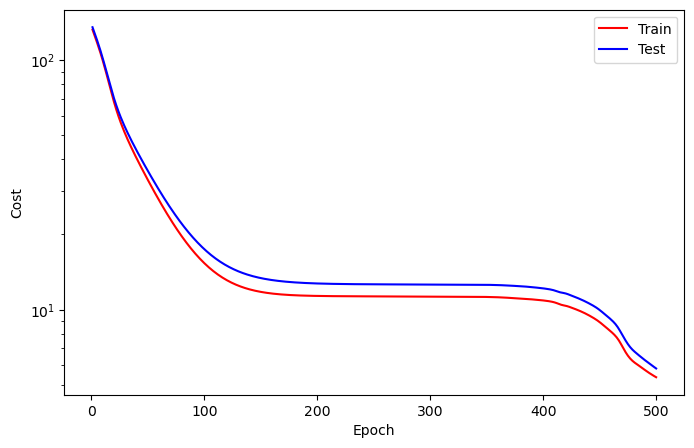


Epoch   501
Train_cost  = 5.3240 | Test_cost  = 5.7634 | 

Epoch   502
Train_cost  = 5.2939 | Test_cost  = 5.7225 | 

Epoch   503
Train_cost  = 5.2649 | Test_cost  = 5.6827 | 

Epoch   504
Train_cost  = 5.2365 | Test_cost  = 5.6439 | 

Epoch   505
Train_cost  = 5.2088 | Test_cost  = 5.6061 | 

Epoch   506
Train_cost  = 5.1817 | Test_cost  = 5.5691 | 

Epoch   507
Train_cost  = 5.1550 | Test_cost  = 5.5331 | 

Epoch   508
Train_cost  = 5.1287 | Test_cost  = 5.4979 | 

Epoch   509
Train_cost  = 5.1030 | Test_cost  = 5.4635 | 

Epoch   510
Train_cost  = 5.0776 | Test_cost  = 5.4298 | 

Epoch   511
Train_cost  = 5.0527 | Test_cost  = 5.3966 | 

Epoch   512
Train_cost  = 5.0283 | Test_cost  = 5.3640 | 

Epoch   513
Train_cost  = 5.0044 | Test_cost  = 5.3320 | 

Epoch   514
Train_cost  = 4.9809 | Test_cost  = 5.3003 | 

Epoch   515
Train_cost  = 4.9578 | Test_cost  = 5.2688 | 

Epoch   516
Train_cost  = 4.9352 | Test_cost  = 5.2374 | 

Epoch   517
Train_cost  = 4.9129 | Test_cost  = 5.2061 

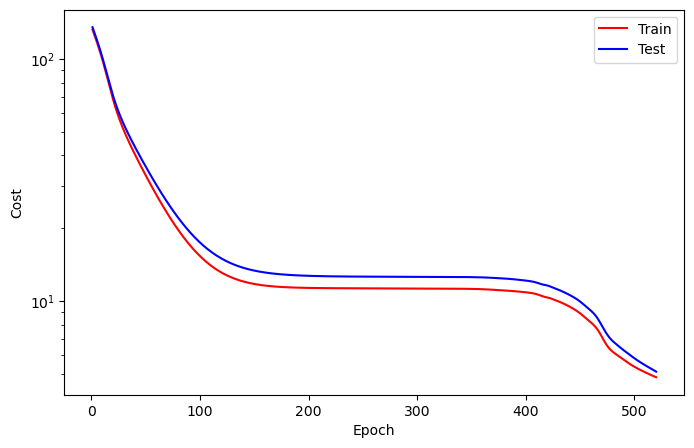


Epoch   521
Train_cost  = 4.8273 | Test_cost  = 5.0837 | 

Epoch   522
Train_cost  = 4.8068 | Test_cost  = 5.0541 | 

Epoch   523
Train_cost  = 4.7866 | Test_cost  = 5.0253 | 

Epoch   524
Train_cost  = 4.7667 | Test_cost  = 4.9972 | 

Epoch   525
Train_cost  = 4.7471 | Test_cost  = 4.9698 | 

Epoch   526
Train_cost  = 4.7277 | Test_cost  = 4.9431 | 

Epoch   527
Train_cost  = 4.7086 | Test_cost  = 4.9169 | 

Epoch   528
Train_cost  = 4.6898 | Test_cost  = 4.8914 | 

Epoch   529
Train_cost  = 4.6712 | Test_cost  = 4.8662 | 

Epoch   530
Train_cost  = 4.6530 | Test_cost  = 4.8414 | 

Epoch   531
Train_cost  = 4.6350 | Test_cost  = 4.8168 | 

Epoch   532
Train_cost  = 4.6173 | Test_cost  = 4.7924 | 

Epoch   533
Train_cost  = 4.5998 | Test_cost  = 4.7681 | 

Epoch   534
Train_cost  = 4.5826 | Test_cost  = 4.7441 | 

Epoch   535
Train_cost  = 4.5656 | Test_cost  = 4.7203 | 

Epoch   536
Train_cost  = 4.5488 | Test_cost  = 4.6968 | 

Epoch   537
Train_cost  = 4.5323 | Test_cost  = 4.6736 

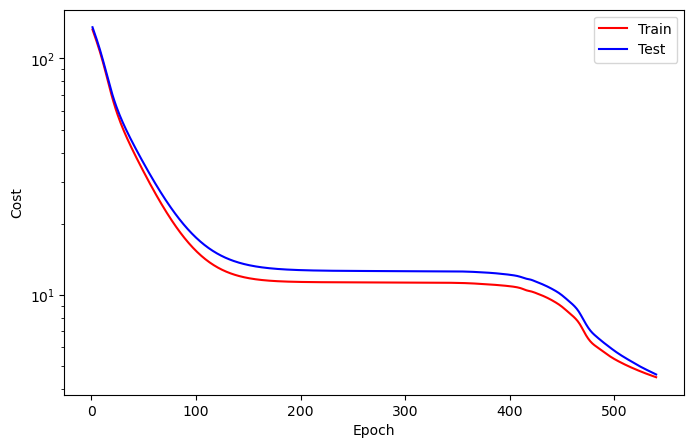


Epoch   541
Train_cost  = 4.4684 | Test_cost  = 4.5845 | 

Epoch   542
Train_cost  = 4.4530 | Test_cost  = 4.5631 | 

Epoch   543
Train_cost  = 4.4378 | Test_cost  = 4.5420 | 

Epoch   544
Train_cost  = 4.4228 | Test_cost  = 4.5210 | 

Epoch   545
Train_cost  = 4.4080 | Test_cost  = 4.5002 | 

Epoch   546
Train_cost  = 4.3934 | Test_cost  = 4.4795 | 

Epoch   547
Train_cost  = 4.3790 | Test_cost  = 4.4590 | 

Epoch   548
Train_cost  = 4.3649 | Test_cost  = 4.4387 | 

Epoch   549
Train_cost  = 4.3508 | Test_cost  = 4.4185 | 

Epoch   550
Train_cost  = 4.3371 | Test_cost  = 4.3985 | 

Epoch   551
Train_cost  = 4.3235 | Test_cost  = 4.3788 | 

Epoch   552
Train_cost  = 4.3100 | Test_cost  = 4.3594 | 


PermissionError: [Errno 13] Permission denied: 'model/GRU/logs.pth'

In [11]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [ ]:
from utils import data4pred, pred4pred

In [ ]:
train_ForC_set = TimeSeriesDataset(t_train, "Temp", 1) # input 1 pred 1
trainForcastloader = DataLoader(train_ForC_set, shuffle=False)

test_ForC_set = TimeSeriesDataset(t_test, "Temp", 1)
testForcastloader = DataLoader(test_ForC_set, shuffle=False)

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_ForC_set, trainForcastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_ForC_set, testForcastloader, device)
plt.title('Test')

In [ ]:
def pred4pred(model, dataset, dataloader, device, n_prior=16, n_forecast=30):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()       

In [ ]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_ForC_set, testForcastloader, device)
plt.title('Test')